This model comprises three components. The autoregressive element (AR) relates the current value to past (lagged) values. The moving average element (MA) assumes that the regression error is a linear combination of past forecast errors. Finally, the integrated component (I) indicates that the data values have been replaced with the difference between their values and the previous ones (and this differencing process may have been performed more than once).

In [1]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


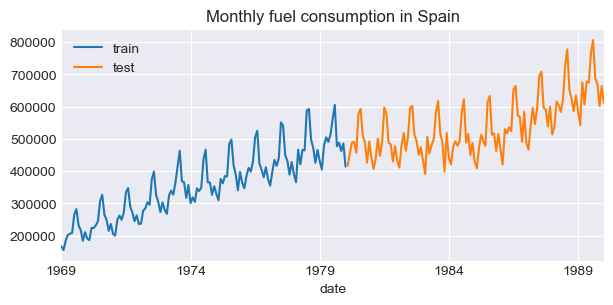

In [2]:
# Download data
# ======================================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/consumos-combustibles-mensual.csv'
)
data = pd.read_csv(url, sep=',')
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data.asfreq('MS')
data = data['litters']
display(data.head(4))

# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

1 - Stationarity: Stationarity means that the statistical properties (mean, variance...) remain constant over time, so time series with trends or seasonality are not stationary. Since ARIMA assumes the stationarity of the data, it is essential to subject the data to rigorous tests, such as the Augmented Dickey-Fuller test, to assess stationarity. If non-stationarity is found, the series should be differenced until stationarity is achieved. This analysis helps to determine the optimal value of the parameter  $d$.

2 - Autocorrelation analysis: Plot the autocorrelation and partial autocorrelation functions (ACF and PACF) to identify potential lag relationships between data points. This visual analysis provides insight into determining appropriate autoregressive (AR) and moving average (MA) terms ( $p$ and  $q$) for the ARIMA model.

3 - Seasonal decomposition: In cases where seasonality is suspected, decomposing the series into trend, seasonal, and residual components using techniques such as moving averages or seasonal time series decomposition (STL) can reveal hidden patterns and help identify seasonality. This analysis helps to determine the optimal values of the parameters  $P,  D,  Q$  and  $m$.

### Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test takes as its null hypothesis that the time series has a unit root - a characteristic of non-stationary time series. Conversely, the alternative hypothesis (under which the null hypothesis is rejected) is that the series is stationary.

* Null Hypothesis (HO): The series is not stationary or has a unit root.

* Alternative hypothesis (HA): The series is stationary with no unit root.

Since the null hypothesis assumes the presence of a unit root, the p-value obtained should be less than a specified significance level, often set at 0.05, to reject this hypothesis. This result indicates the stationarity of the series. The adfuller() function within the Statsmodels library is a handy tool for implementing the ADF test. Its output includes four values: the p-value, the value of the test statistic, the number of lags included in the test, and critical value thresholds for three different levels of significance.

### Kwiatkowski-Phillips-Schmidt-Shin test (KPSS)

The KPSS test checks if a time series is stationary around a mean or linear trend. In this test, the null hypothesis is that the data are stationary, and we look for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) rejects the null hypothesis and suggest that differencing is required. Statsmodels library provides an implementation of the KPSS test via the kpss() function.

While both tests are used to check stationarity,
* The KPSS test focuses on the presence of trends, and a low p-value indicates non-stationarity due to a trend.
* The ADF test focuses on the presence of a unit root, and a low p-value indicates that the time series does not have a unit root, suggesting it might be stationary.
It's common to use both tests together to get a more comprehensive understanding of the stationarity properties of a time series.

Test stationarity for original series
-------------------------------------
ADF Statistic: -0.44612980998228685, p-value: 0.9021071923942653
KPSS Statistic: 2.2096370946978388, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -3.641727690032322, p-value: 0.00501160500213726
KPSS Statistic: 0.31327116235727637, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -8.233942641656066, p-value: 5.959599575493918e-13
KPSS Statistic: 0.08065668267482097, p-value: 0.1


<Axes: title={'center': 'Differenced order 2'}, xlabel='date'>

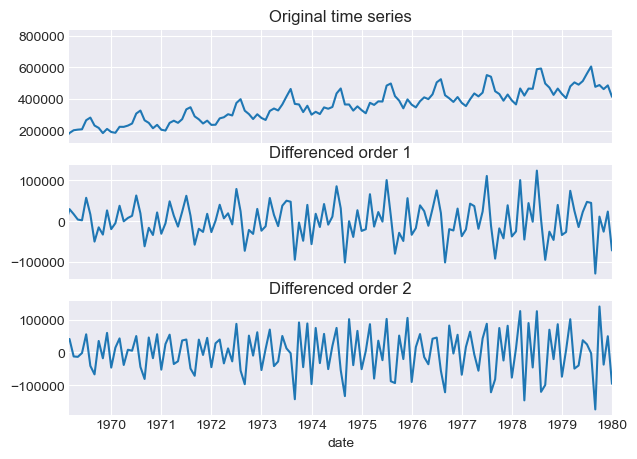

In [3]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2')

### Autocorrelation Function (ACF)

The ACF calculates the correlation between a time series and its lagged values. Within the context of ARIMA modeling, a sharp drop-off in the ACF after a few lags indicates that the data have a finite autoregressive order. The lag at which the ACF drops off provides an estimation of the value of  $q$. If the ACF displays a sinusoidal or damped sinusoidal pattern, it suggests seasonality is present and requires consideration of seasonal orders in addition to non-seasonal orders.

### Partial Autocorrelation Function (PACF)

The PACF measures the correlation between a lagged value and the current value of the time series, while accounting for the effect of the intermediate lags. In the context of ARIMA modeling, if the PACF sharply cuts off after a certain lag, while the remaining values are within the confidence interval, it suggests an AR model of that order. The lag, at which the PACF cuts off, gives an idea of the value of  $p$.

Some rules of thumb are:
* Take the order of AR term p to be equal to as many lags that crosses the significance limit in the PACF plot.

* Take the order of MA term q to be equal to as many lags that crosses the significance limit in the ACF plot.

* If the ACF cuts off at lag q and the PACF cuts off at lag p, one could start with an ARIMA(p, d, q) model.

* If only the PACF stops after lag p, one could start with an AR(p) model.

* If only the ACF stops after lag q, one could start with an MA(q) model.

These guidelines provide a useful starting point when selecting the orders of an ARIMA model and can be adjusted according to the specific characteristics of the data in question.

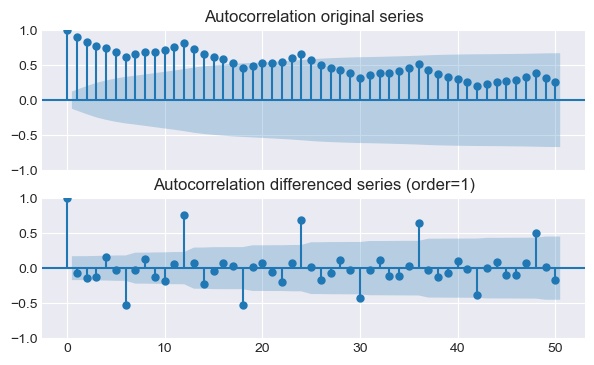

In [4]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)')

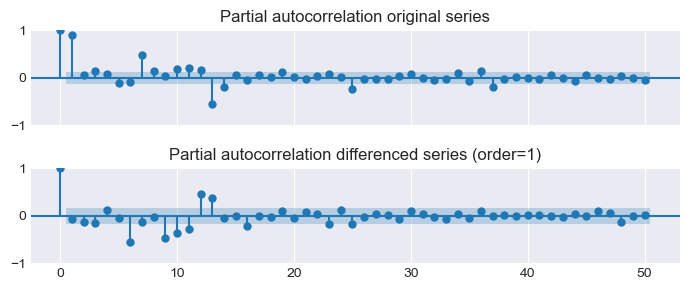

In [5]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout()

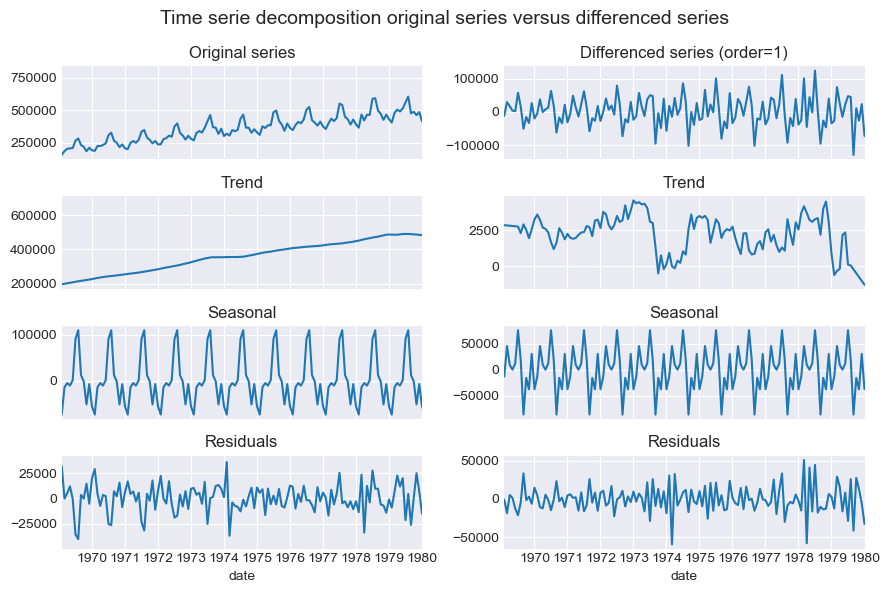

In [6]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

Based on the results of the exploratory analysis, utilizing a combination of first-order differencing and seasonal differencing may be the most appropriate approach. First-order differencing is effective in capturing transitions between observations and highlighting short-term fluctuations. Concurrently, seasonal differencing, which covers a period of 12 months and represents the shift from one year to the next, effectively captures the inherent cyclic patterns in the data. This approach allows us to achieve the necessary stationarity for the following ARIMA modeling process.

In [7]:
# First order differentiation combined with seasonal differentiation
# ==============================================================================
data_diff_1_12 = data_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(data_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(data_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -4.387457230769959, p-value: 0.0003123773271126894
KPSS Statistic: 0.06291573421251051, p-value: 0.1


In [8]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")

model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Mon, 25 Sep 2023   AIC                           2722.103
Time:                                    22:40:47   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+33. Standard errors may be unstable.
"""

The model summary shows a lot of information about the fitting process:

* Model Fit Statistics: This part includes several statistics that help you evaluate how well the model fits the data:

    * Log-Likelihood: A measure of how well the model explains the observed data. When fitting an ARIMA model, negative log-likelihood values will be encounter, with more negative values indicating a poorer fit to the data, and values closer to zero indicating a better fit.

    * AIC (Akaike Information Criterion): A goodness-of-fit metric that balances the fit of the model with its complexity. Lower AIC values are preferred.

    * BIC (Bayesian Information Criterion): Similar to AIC, but penalizes model complexity more. As with AIC, lower BIC values are better.

    * HQIC (Hannan-Quinn Information Criterion): Another model selection criterion, similar to AIC and BIC.

* Coefficients: This table lists the estimated coefficients for the parameters of the model. It includes both autoregressive (AR) and moving average (MA) parameters, as well as any exogenous variables if they are included in the model. It also includes the standard errors associated with the estimated coefficients to indicate the uncertainty in the parameter estimates, their P-values, which are used to assess the significance of each coefficient, and the 95% confidence interval.

* Model diagnostics: This section provides information about the residuals (the differences between the observed values (training values) and their predicted values from the model):

    * Ljung-Box test: A test for autocorrelation in the residuals.

    * Jarque-Bera test: A test of the normality of the residuals.

    * Skewness and kurtosis: Measures of the shape of the distribution of the residuals.

In [9]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(4))

1980-02-01    407504.056948
1980-03-01    473997.245815
1980-04-01    489983.091481
1980-05-01    485517.462870
Freq: MS, Name: predictions_statsmodels, dtype: float64

In [10]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')

model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()

warnings.filterwarnings("default")

In [11]:
# Prediction
# ==============================================================================
predictions_skforecast = model.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']
display(predictions_skforecast.head(4))

,skforecast
1980-02-01,407504.056948
1980-03-01,473997.245815
1980-04-01,489983.091481
1980-05-01,485517.462870


In [12]:
# ARIMA model with pdmarima.Sarimax
# ==============================================================================
model = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Mon, 25 Sep 2023   AIC                           2723.498
Time:                                    22:43:16   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.917    1684.753
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+27. Standard errors may be unstable.
"""

In [13]:
# Prediction
# ==============================================================================
predictions_pdmarima = model.predict(len(data_test))
predictions_pdmarima.name = 'predictions_pdmarima'
display(predictions_pdmarima.head(4))

1980-02-01    406998.311393
1980-03-01    472944.444442
1980-04-01    488389.125322
1980-05-01    483432.075663
Freq: MS, Name: predictions_pdmarima, dtype: float64

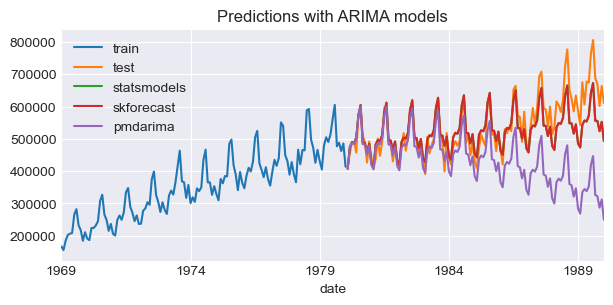

In [14]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_statsmodels.plot(ax=ax, label='statsmodels')
predictions_skforecast.plot(ax=ax, label='skforecast')
predictions_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [15]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))
predictions.head(4)

1980-02-01    407504.056948
1980-03-01    473997.245815
1980-04-01    489983.091481
1980-05-01    485517.462870
Freq: MS, Name: pred, dtype: float64

In [16]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data,
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

print(f"Metric (mean_absolute_error): {metric}")
display(predictions.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 --

c:\Users\kevol\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/10 [00:00<?, ?it/s]

Metric (mean_absolute_error): 19611.236349751758


,pred
1980-02-01,407504.056948
1980-03-01,473997.245815
1980-04-01,489983.091481
1980-05-01,485517.462870


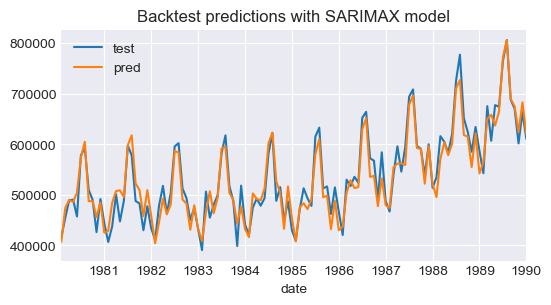

In [17]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend()